# はじめに
機械学習モデルの出力から、どの程度プライバシーが漏洩する危険性があるかを評価します。  


### 概要
- メンバーシップ推定攻撃で、モデルが教師データをどの程度記憶しているか評価する。
- 尤度比に基づいて教師データに含まれていたか判定するメンバーシップ推定攻撃の成功率を確認する。  


### 参考資料
- N. Carlini et al., Membership Inference Attacks From First Principles, IEEE S&P, 2022  
https://ieeexplore.ieee.org/abstract/document/9833649
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

# メンバーシップ推定攻撃
メンバーシップ推定攻撃は、教師データがどの程度モデルに記憶されているかに基づいて、プライバシー侵害の危険性を評価する際に用いられます。

### 基本的な考え方
下記の図のように、あるデータ（以降、ターゲット）を含まないデータセットと、ターゲットをデータを含むデータセットで学習したモデル$F_{out}$と$F_{in}$を考えます。  
モデルがターゲットを記憶している場合、$F_{out}$と$F_{in}$の出力が大きく変化するため、ターゲットが教師データに含まれていたかどうかの判定は、容易に行うことができるはずです。  

この観察に基づいて、   
　　教師データに含まれていたかを判定可能（メンバーシップ推定攻撃が成功） ⇒ モデルが教師データを記憶 ⇒ 教師データのプライバシーが保護されていない  
という考えに基づいてプライバシー保護の評価を行います。



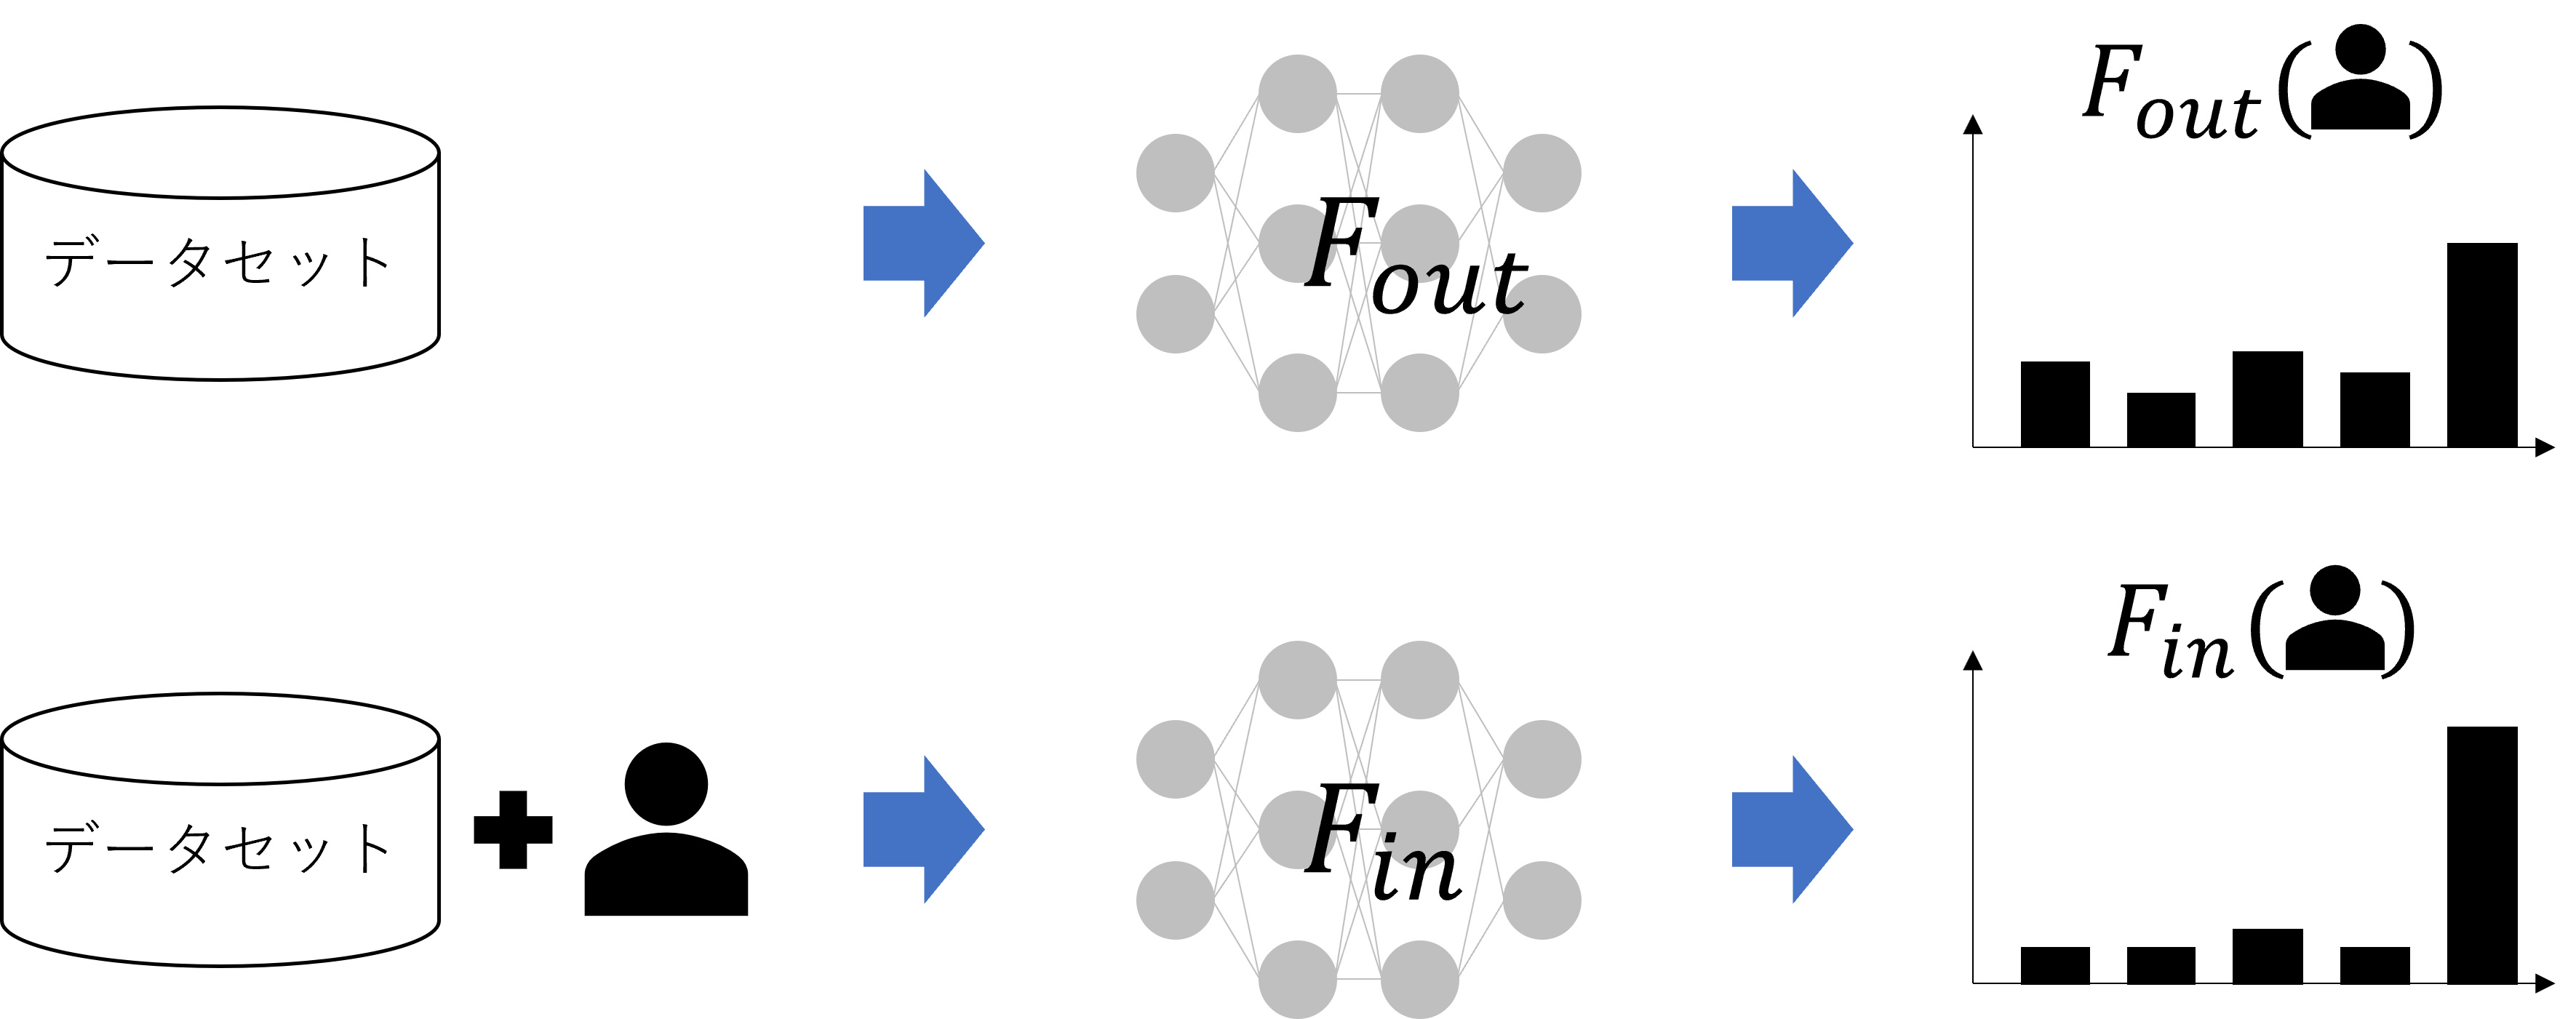


### 評価の手順
尤度比に基づくメンバーシップ推定攻撃では、判定対象のデータごとに下記の手順で判定を行います。  
1. shadow datasetの用意  
判定対象のデータを含むデータセット$D_{in}^1 \cdots D_{in}^k$と含まないデータセットセット$D_{out}^1 \cdots D_{out}^k$をそれぞれ$k$個ずつ用意します。  
2. shadow modelの学習  
用意したデータセットを用いてモデル$F_{in}^1 \cdots F_{out}^k$の学習を行います。  
3. モデルの出力の用意  
判定対象のデータ$x$をモデルに入力し、教師データに含まれていた場合（in）と含まれていない場合（out）の出力$F_{in}^1(x) \cdots F_{out}^k(x)$を取得します。  
4. 確率密度関数の計算  
モデルの出力から、inとoutそれぞれの確率密度関数$p_{in}$と$p_{out}$を計算します。  
5. メンバーシップ推定攻撃  
攻撃対象のモデルの出力$F(x)$に関する尤度比$\frac{p_{in}(F(x))}{p_{out}(F(x))}$を計算します。尤度比が閾値を超えた場合に教師データに使用されていたと判定します。  


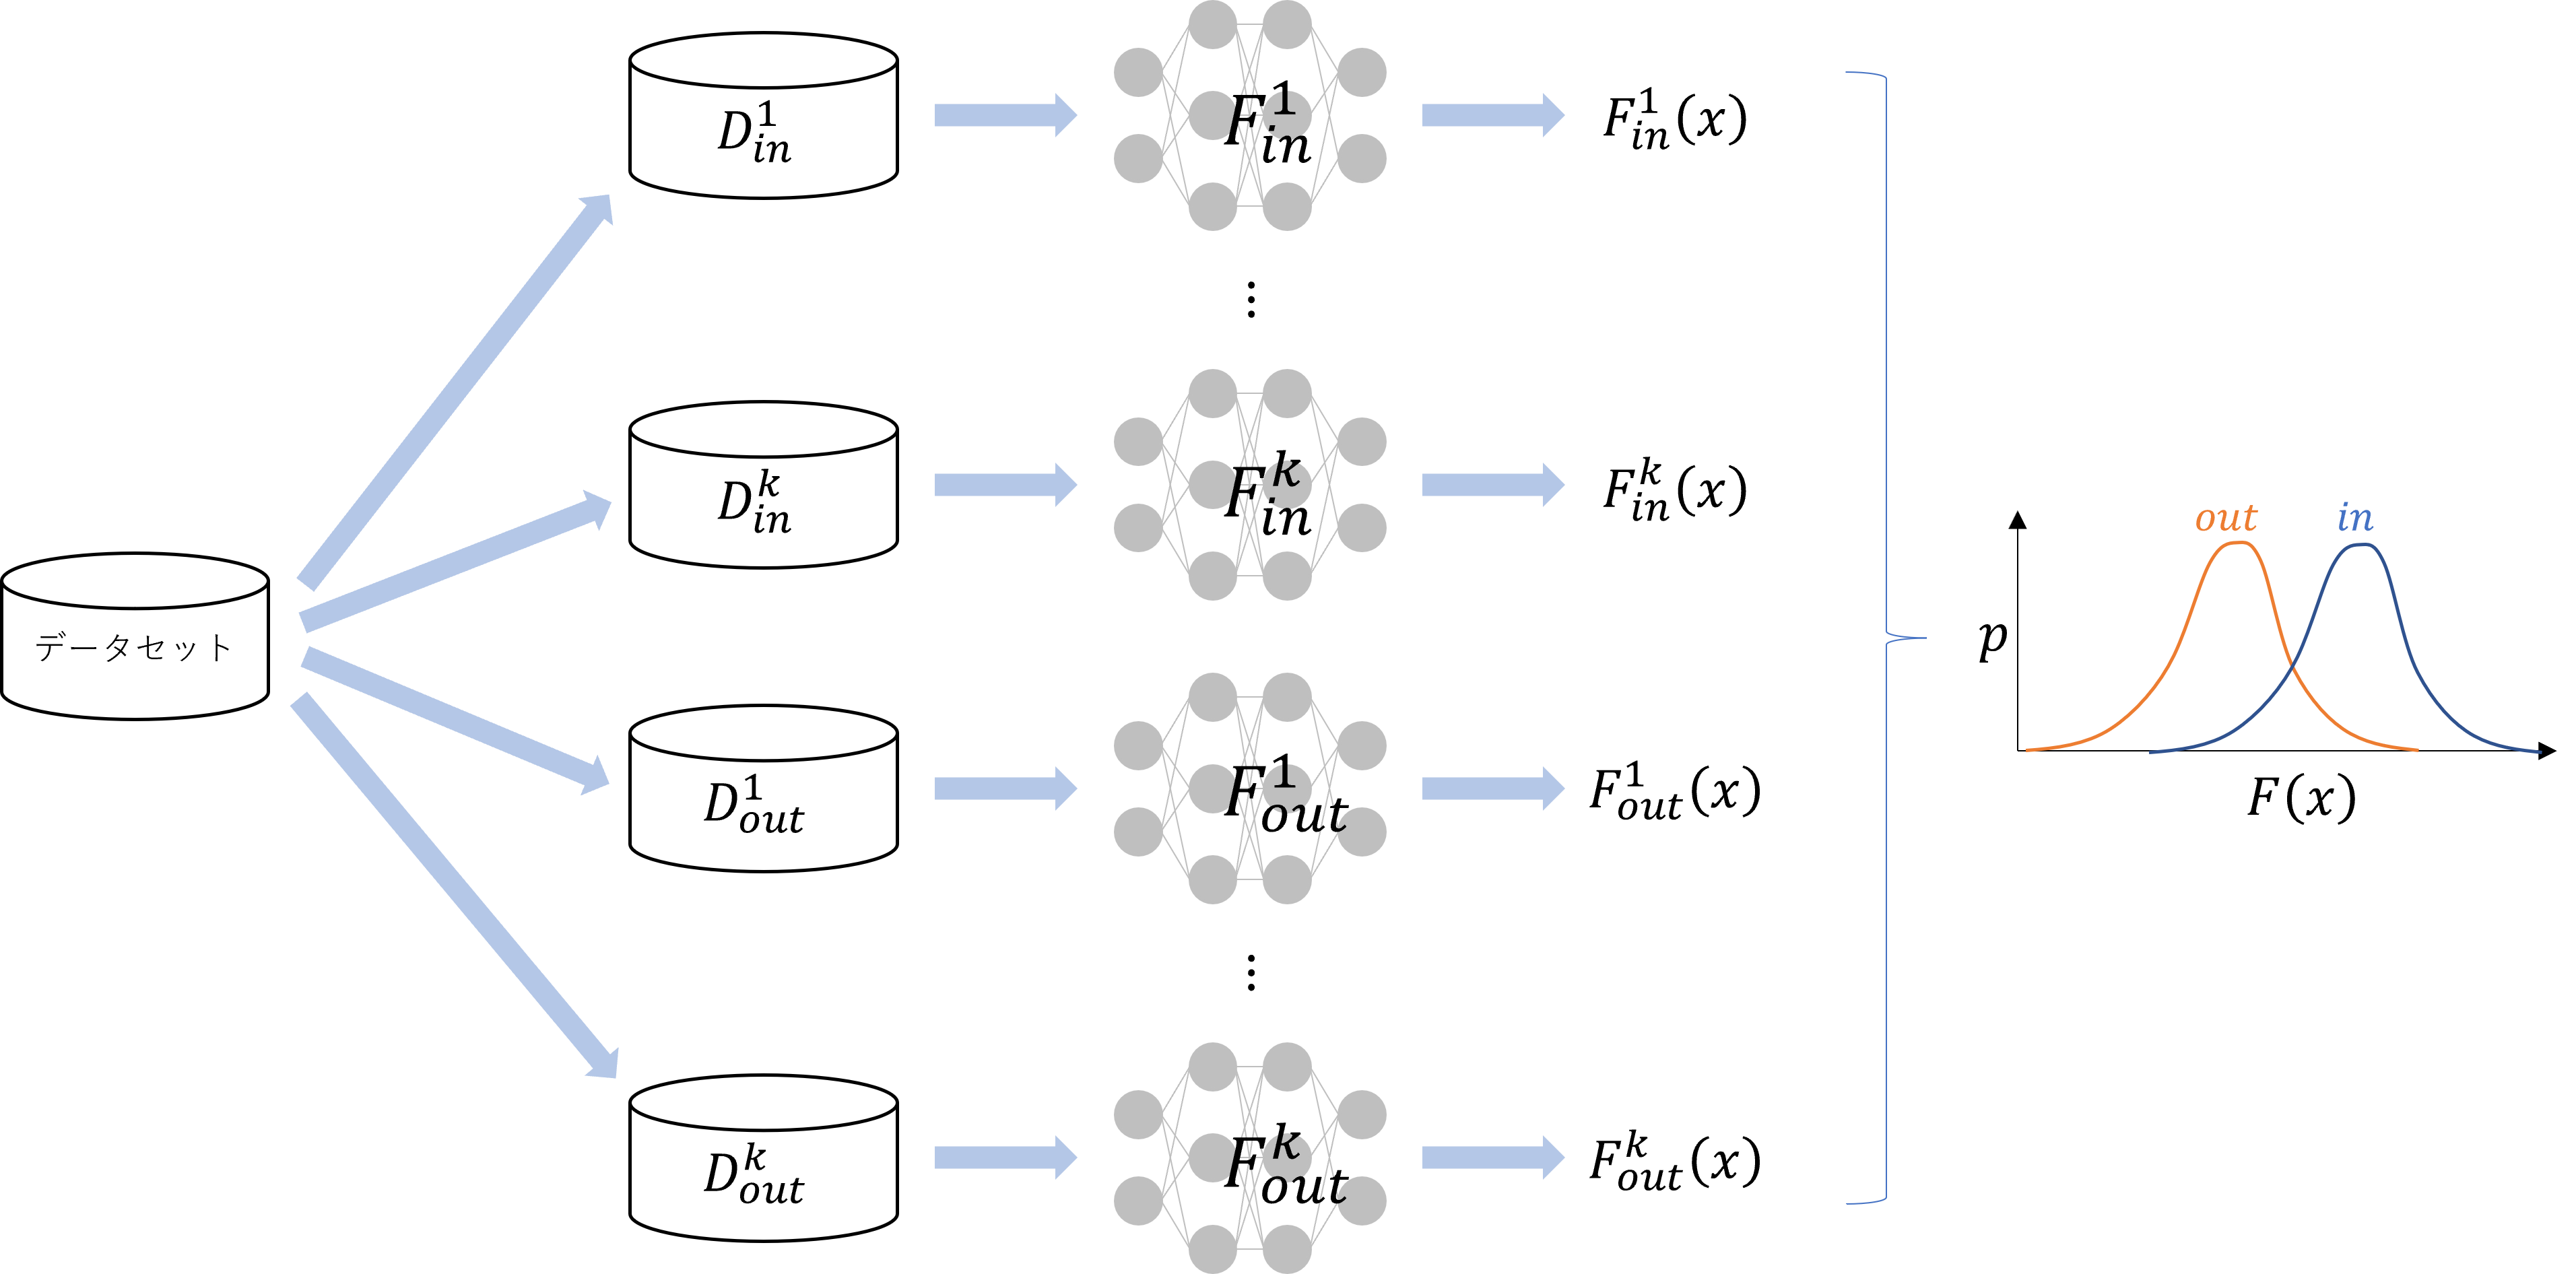

# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import sys
import os

import torch
import torchvision
from torch.utils.data import DataLoader

import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import scipy.stats as stats


!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 10.6 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
PyTorch: 2.0.0+cu118
Torchvision: 0.15.1+cu118
Opacus: 1.4.0
Sat May 13 02:03:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

### 3. データセットの用意  

カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を、torchvisionを用いて取得します。  
全てのデータに、下記の操作を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化

差分プライバシーを適用しない場合のみ、data augmentationを適用するために、data augmentation用の関数も用意しておきます。


In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

# for data augmentation
trans = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
    ]
)


100%|██████████| 170498071/170498071 [00:12<00:00, 13115635.04it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### 4. 学習

#### 学習の関数化
今回は、異なる条件で複数回学習を実行するため、学習部分を関数として定義します。  
教師データの分割では、再現可能なようにシードを固定しています。  
学習したモデルは今後再利用可能なように、保存しておきます。  
学習データを半分にしているので、エポック数は30としました。

In [ ]:
def training(batch_size = 512, sigma=1.0, c=1.0, idx=0, dp_flag=0, dir='/content/drive/MyDrive/model'):    
    if dp_flag == 1:
        fname = f"{dir}/model_dp_{idx}.pt"
    else:
        fname = f"{dir}/model_{idx}.pt"

    if os.path.exists(fname):
        print(f'{fname} exist')
        return
        
    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    train_dataloader = DataLoader(train_in, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    model = torchvision.models.resnet18(num_classes=10)
    # fix model for DP-SGD
    if dp_flag == 1:
        model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)

    # make optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # DP-SGD settig
    if dp_flag == 1:
        privacy_engine = opacus.PrivacyEngine()
        model, optimizer, train_dataloader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            noise_multiplier=sigma,
            max_grad_norm=c,
        )

    # training 
    pbar = tqdm(range(30), desc=f"[idx: {idx}]")
    for epoch in pbar:
            
        if dp_flag == 1:
            with BatchMemoryManager(
                data_loader=train_dataloader, 
                max_physical_batch_size=64, 
                optimizer=optimizer
            ) as memory_safe_data_loader:
                model.train()
                for (X, y) in memory_safe_data_loader:
                    X, y = X.to(device), y.to(device)

                    # optimization step
                    optimizer.zero_grad()
                    pred = model(X)
                    loss = criterion(pred, y)
                    loss.backward()
                    optimizer.step()
        else:
            model.train()
            for (X, y) in train_dataloader:
                X, y = X.to(device), y.to(device)

                # data augmentation for non-DP
                X = trans(X)

                # optimization step
                optimizer.zero_grad()
                pred = model(X)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()

    # calculate epsilon
    if dp_flag == 1:
        epsilon = privacy_engine.get_epsilon(1e-5)
    else:
        epsilon = -1
    
    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'epsilon: {epsilon}, test accuracy: {test_acc}')

    #save model
    if dp_flag == 1:
        torch.save(model._module.state_dict(), f"{dir}/model_dp_{idx}.pt")
    else:
        torch.save(model.state_dict(), f"{dir}/model_{idx}.pt")

#### 学習の実行
Google driveにモデルを保存するために、マウントします。  
その後、DP-SGDを適用しない場合と、DP-SGDを適用した場合それぞれでモデルの学習を行います。  
今回は、shadow modelに29個のモデルを使用するため、合計で30個のモデルの学習を行います。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for idx in range(30):
    training(batch_size=128, idx=idx)
    training(dp_flag=1, idx=idx)

/content/drive/MyDrive/model/model_0.pt exist
/content/drive/MyDrive/model/model_dp_0.pt exist
/content/drive/MyDrive/model/model_1.pt exist
/content/drive/MyDrive/model/model_dp_1.pt exist
/content/drive/MyDrive/model/model_2.pt exist
/content/drive/MyDrive/model/model_dp_2.pt exist
/content/drive/MyDrive/model/model_3.pt exist
/content/drive/MyDrive/model/model_dp_3.pt exist
/content/drive/MyDrive/model/model_4.pt exist
/content/drive/MyDrive/model/model_dp_4.pt exist
/content/drive/MyDrive/model/model_5.pt exist
/content/drive/MyDrive/model/model_dp_5.pt exist
/content/drive/MyDrive/model/model_6.pt exist
/content/drive/MyDrive/model/model_dp_6.pt exist
/content/drive/MyDrive/model/model_7.pt exist
/content/drive/MyDrive/model/model_dp_7.pt exist
/content/drive/MyDrive/model/model_8.pt exist
/content/drive/MyDrive/model/model_dp_8.pt exist
/content/drive/MyDrive/model/model_9.pt exist
/content/drive/MyDrive/model/model_dp_9.pt exist
/content/drive/MyDrive/model/model_10.pt exist
/co

### 5. メンバーシップ推定攻撃

#### 確率密度関数の計算  
インデックスが1-29のモデルを使用して、確率密度関数を求めす。  
確率密度関数を正規分布として求めるために、モデルの出力を下記の通りスケーリングします。  
$\phi(F(x)_y) = \log(F(x)_y) - \log(\sum_{y'\neq y}F(x)_{y'})$  
ここで、$F(x)_y$は正解クラス$y$の確信度です。  

In [ ]:
def calc_params(target_idx=0, n_models=30, dp_flag=0, dir='/content/drive/MyDrive/'):
    pred_mat = []
    ans_mat = []
    for idx in tqdm(range(n_models)):
        if idx == target_idx:
            continue

        #split training data
        train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

     
        # make dataloader
        loader = DataLoader(training_data, batch_size=1024, shuffle=False)

        # make model
        model = torchvision.models.resnet18(num_classes=10)
        if dp_flag == 1:
            model = ModuleValidator.fix(model)

        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        if dp_flag == 1:
            fname = f"{dir}/model/model_dp_{idx}.pt"
        else:
            fname = f"{dir}/model/model_{idx}.pt"
        
        model.load_state_dict(torch.load(fname))
        # print(f'{fname} loaded')

        ans_list = np.zeros(len(training_data))
        ans_list[train_in.indices] = 1

        # predict
        pred_list = []
        with torch.no_grad():
            for X, y in loader:
                X = X.to(device)

                pred =  torch.nn.Softmax()(model(X)).to('cpu').numpy()
                
                # log scaling
                tmp = np.sum(pred, axis=1)
                for i in range(pred.shape[0]):
                    pred_list.append(np.log(pred[i,y[i]]+1e-10) - np.log(tmp[i] - pred[i,y[i]]+1e-10))
                
        pred_mat.append(pred_list)
        ans_mat.append(ans_list)
    
    pred_mat = np.stack(pred_mat).T
    ans_mat = np.stack(ans_mat).T
    print(pred_mat.shape)
    print(ans_mat.shape)

    mean_in = []
    std_in = []
    for i in range(pred_mat.shape[0]):
        mean_in.append(np.mean(pred_mat[i,ans_mat[i]==1]))
        std_in.append(np.std(pred_mat[i,ans_mat[i]==1]))
    mean_in = np.array(mean_in)
    std_in = np.array(std_in)

    mean_out = []
    std_out = []
    for i in range(pred_mat.shape[0]):
        mean_out.append(np.mean(pred_mat[i,ans_mat[i]==0]))
        std_out.append(np.std(pred_mat[i,ans_mat[i]==0]))
    mean_out = np.array(mean_out)
    std_out = np.array(std_out)

    
    plt.figure(figsize=(15,3))
    for i in range(5):
        plt.subplot(151 + i)
        plt.hist(pred_mat[i,ans_mat[i]==1], alpha=0.5, label='IN')
        plt.hist(pred_mat[i,ans_mat[i]==0], alpha=0.5, label='OUT')
        plt.legend()
    plt.show()

    inference = []
    ans = []
    for i in range(pred_mat.shape[0]):
        inference.append((stats.norm.pdf(pred_mat[i], loc=mean_in[i], scale=(std_in[i]+1e-5))+1e-5) / (stats.norm.pdf(pred_mat[i],loc=mean_out[i],scale=(std_out[i]+1e-5))+1e-5))
        ans.append(ans_mat[i])

    inference = np.concatenate(inference)
    ans = np.concatenate(ans)

    fpr, tpr, thresholds = metrics.roc_curve(ans, inference)
    TP = tpr*np.sum(ans)
    TN = (1-fpr)*np.sum(1-np.array(ans))
    accuracy = (TP+TN) / float(len(ans))
    plt.figure(figsize=(3,2))
    plt.plot(thresholds, accuracy)
    plt.xlim(0,5)
    plt.ylabel('MIA accuracy')
    plt.xlabel('Threshold')
    plt.show()

    i = np.argmax(accuracy)

    print(f'Best MIA accuracy: {accuracy[i]}, threshold: {thresholds[i]}')

    if dp_flag == 1:
        f = open(dir + f'/data/lira_params_dp_{target_idx}.pkl', 'wb')
    else:
        f = open(dir + f'/data/lira_params_{target_idx}.pkl', 'wb')

    pickle.dump((mean_in, std_in, mean_out, std_out, thresholds[i]), f)

100%|██████████| 30/30 [09:41<00:00, 19.39s/it]


(50000, 29)
(50000, 29)


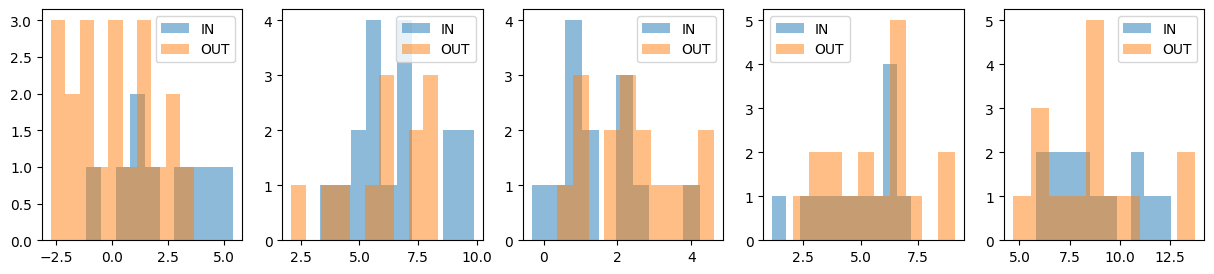

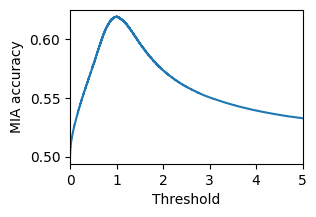

Best MIA accuracy: 0.6192124137931034, threshold: 1.0094997579519547


100%|██████████| 30/30 [10:19<00:00, 20.65s/it]


(50000, 29)
(50000, 29)


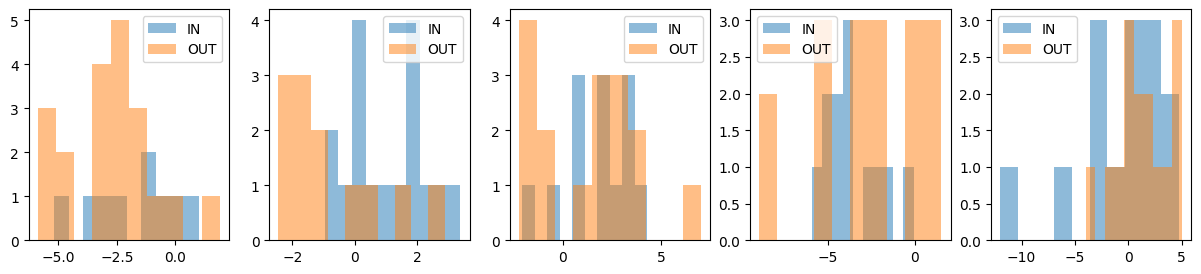

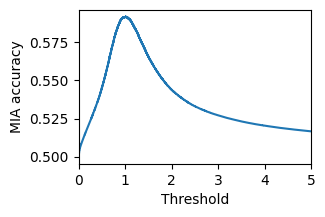

Best MIA accuracy: 0.5917937931034483, threshold: 1.0110267030831237


In [ ]:
calc_params(target_idx=0)
calc_params(dp_flag=1, target_idx=0)

#### メンバーシップ推定攻撃の実行
算出した確率密度関数を用いて、尤度比に基づくメンバーシップ推定攻撃を行います。

In [ ]:
def MIA(idx=0, dp_flag=0, dir='/content/drive/MyDrive/'):
    
    if dp_flag == 1:
        f = open(dir + f'/data/lira_params_dp_{idx}.pkl', 'rb')
    else:
        f = open(dir + f'/data/lira_params_{idx}.pkl', 'rb')

    mean_in, std_in, mean_out, std_out, threshold = pickle.load(f)

    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    loader = DataLoader(training_data, batch_size=1024, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    model = torchvision.models.resnet18(num_classes=10)
    if dp_flag == 1:
        model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)


    if dp_flag == 1:
        fname = f"{dir}/model/model_dp_{idx}.pt"
    else:
        fname = f"{dir}/model/model_{idx}.pt"
    
    model.load_state_dict(torch.load(fname))
    print(f'{fname} loaded')

    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'test accuracy: {test_acc}')

    ans = np.zeros(len(training_data))
    ans[train_in.indices] = 1

    # predict
    pred_list = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)

            pred =  torch.nn.Softmax()(model(X)).to('cpu').numpy()
            
            # log scaling
            tmp = np.sum(pred, axis=1)
            for i in range(pred.shape[0]):
                pred_list.append(np.log(pred[i,y[i]]+1e-10) - np.log(tmp[i] - pred[i,y[i]]+1e-10))
            
    inference = []
    for i in range(len(pred_list)):
        inference.append((stats.norm.pdf(pred_list[i], loc=mean_in[i], scale=(std_in[i]+1e-5))+1e-5) / (stats.norm.pdf(pred_list[i],loc=mean_out[i],scale=(std_out[i]+1e-5))+1e-5))
    inference = np.array(inference)
    
    inference_binary = np.zeros(ans.shape)
    inference_binary[inference > threshold] = 1    
    mia_acc = metrics.accuracy_score(ans, inference_binary)
    print(f'MIA accuracy: {mia_acc}')

    cm = metrics.confusion_matrix(ans, inference_binary)
    print(cm)    
    print()

    fpr, tpr, threshold = metrics.roc_curve(y_true = ans, y_score = inference)
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    plt.subplot(122)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


/content/drive/MyDrive//model/model_0.pt loaded
test accuracy: 0.7793
MIA accuracy: 0.5416
[[13813 11187]
 [11733 13267]]



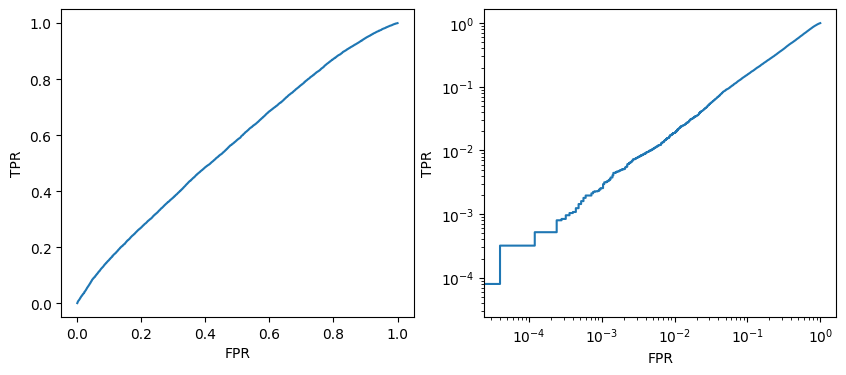

/content/drive/MyDrive//model/model_dp_0.pt loaded
test accuracy: 0.5036
MIA accuracy: 0.50752
[[12665 12335]
 [12289 12711]]



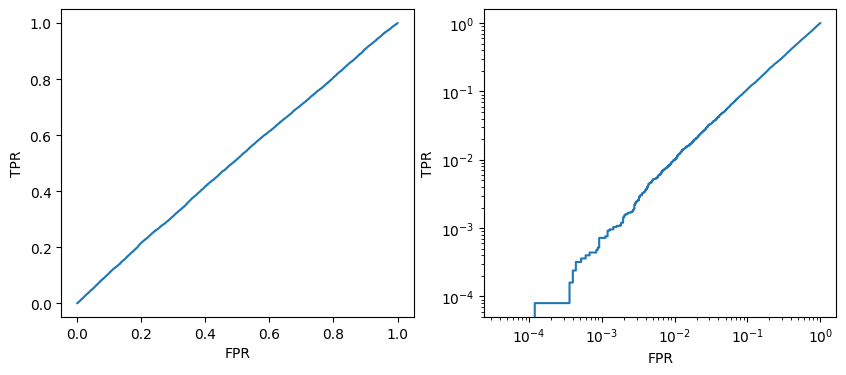

In [ ]:
MIA()
MIA(dp_flag=1)

# おわりに


### 今回の結果
尤度比ベースのメンバーシップ推定攻撃の精度は、他のメンバーシップ推定攻撃とあまり変わりませんでした。  
ただし、差分プライバシーを適用しない場合の低FPRの範囲のTPRは、少し高くなっているように見えます。  
攻撃対象モデルの学習の設定、shadow modelの学習に用いるデータセットの設定などによって結果は異なると考えられるため、様々な設定で実験をする必要がります。


### 次にやること
メンバーシップ推定攻撃と差分プライバシーとの関連について紹介しようと思っています。
